In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
dataset="bank-additional-full.csv"
bankdata=pd.read_csv(dataset, delimiter=";")
bankdata["response"] = bankdata.y.map({'no':0, 'yes':1})

bankdata.drop(["y"],axis=1, inplace=True)
#bankdata.info()
#(bankdata.response==0).sum()

#bankdata.age.unique()

In [3]:
bankdata.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [85]:
#boxplot from dataframe
#bankdata.boxplot('duration','y',rot = 50,figsize=(5,6))

In [3]:
#The method .copy() is used here so that any changes made in new DataFrame don't get reflected in the original one
cat_bankdata = bankdata.select_dtypes(include=['object']).copy() #dataframe of columns with object type columns

#print(cat_bankdata.isnull().values.sum()) #checking for the null values
#print(cat_bankdata.isnull().sum()) #check the column-wise distribution of null values
int_float_bankdata= bankdata.select_dtypes(include=['int64','float64']).copy() #dataframe of columns with int64,float64 type columns
int_float_bankdata.head() #includes response


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,response
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0


In [4]:
#converting categories into numeric types(numeric encoding)

cat_column=cat_bankdata.columns.tolist()

for i in cat_column:
    cat_bankdata[i] = cat_bankdata[i].astype('category')
    cat_bankdata[i] = cat_bankdata[i].cat.codes
    
cat_bankdata.head() 

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,3,1,0,0,0,0,1,6,1,1
1,7,1,3,1,0,0,1,6,1,1
2,7,1,3,0,2,0,1,6,1,1
3,0,1,1,0,0,0,1,6,1,1
4,7,1,3,0,0,2,1,6,1,1


In [5]:
#Removing Quasi-Constant features
#Constant features are the type of features that contain only one value for all the outputs in the dataset. 
#Constant features provide no information that can help in classification of the record at hand. 

from sklearn.feature_selection import VarianceThreshold

var_bankdata=pd.concat([int_float_bankdata,cat_bankdata],axis=1)

#EX/ threshold=0.1 which means that if the variance of the values in a column is less than 0.1, remove those columns.
#In other words, remove feature column where approximately 99% of the values are similar.
variance_filter = VarianceThreshold(threshold=0.1)
bankdata_filtered=variance_filter.fit(var_bankdata)  

#Now to get all the features that are NOT CONSTANT, we can use the get_support() method of the filter that we created
len(var_bankdata.columns[variance_filter.get_support()]) 

#the number of constant features with the help of the following script:
constant_columns = [column for column in var_bankdata.columns  
                    if column not in var_bankdata.columns[variance_filter.get_support()]]

#print(variable_columns)
#print(int_float_bankdata.columns[variance_filter.get_support()])
bankdata_filtered=var_bankdata[var_bankdata.columns[variance_filter.get_support()]]

bankdata_filtered.info()  #not include "response"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
age               41188 non-null int64
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
job               41188 non-null int8
marital           41188 non-null int8
education         41188 non-null int8
default           41188 non-null int8
housing           41188 non-null int8
loan              41188 non-null int8
contact           41188 non-null int8
month             41188 non-null int8
day_of_week       41188 non-null int8
poutcome          41188 non-null int8
dtypes: float64(5), int64(5), int8(10)
memory usage: 3.5 MB


In [6]:
constant_columns

['response']

In [7]:
#Let's use chi-square test to understand relationship between categorical variables and target variable.
#Null Hypothesis which is these features are independent and have no relationship with target variable.

from scipy.stats import chi2_contingency

no_relation_list=[]
for i in cat_bankdata.columns.tolist():
    csq=chi2_contingency(pd.crosstab(bankdata["response"], cat_bankdata[i]))
    print("P-value: ",i, ">>",csq[1])
    if csq[1]>0.05:
        no_relation_list.append(i)

P-value:  job >> 4.189763287563861e-199
P-value:  marital >> 2.068014648442211e-26
P-value:  education >> 3.3051890144025054e-38
P-value:  default >> 5.1619579513916376e-89
P-value:  housing >> 0.05829447669453452
P-value:  loan >> 0.5786752870441754
P-value:  contact >> 1.5259856523129964e-189
P-value:  month >> 0.0
P-value:  day_of_week >> 2.9584820052785324e-05
P-value:  poutcome >> 0.0


In [8]:
#print(no_relation_column)  #returns ['housing', 'loan']
cat_bankdata = bankdata.select_dtypes(include=['object']).copy() #reassigning cat_bankdata for one-hot-encoding
cat_bankdata.drop(columns=list(no_relation_list), axis=1, inplace=True)  
cat_bankdata.head()

,job,marital,education,default,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,telephone,may,mon,nonexistent
2,services,married,high.school,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,telephone,may,mon,nonexistent


In [9]:
int_float_bankdata.columns

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'response'],
      dtype='object')

In [10]:
#Removing Correlated Features
#Two or more than two features are correlated if they are close to each other in the linear space.
#Correlation between the output observations and the input features is very important and such features should be retained.
#Removing Correlated Features using corr() method returns a correlation matrix containing correlation between all the columns of the dataframe

correlated_features = set()   #creating empty set
correlation_matrix = int_float_bankdata.corr()  

#print(correlation_matrix)


for i in range(len(correlation_matrix.columns)):  
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

#print(correlated_features)
#These correlated columns convey similar information to the learning algorithm and therefore, should be removed            

#The following script removes these columns from the dataset:


In [11]:
int_float_bankdata.drop(columns=list(correlated_features), axis=1).head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,response
0,56,261,1,999,0,1.1,93.994,-36.4,0
1,57,149,1,999,0,1.1,93.994,-36.4,0
2,37,226,1,999,0,1.1,93.994,-36.4,0
3,40,151,1,999,0,1.1,93.994,-36.4,0
4,56,307,1,999,0,1.1,93.994,-36.4,0


In [12]:
#creating dummy variables from categorical features (One-Hot encoding)>> this has the benefit of not weighting a value improperly.
#sklearn has "LabelBinarizer" class for one- hot encoding

cat_bankdata_dummy = cat_bankdata.copy()
cat_column_list=cat_bankdata.columns.tolist()

cat_bankdata_dummy = pd.get_dummies(cat_bankdata_dummy, columns=cat_column_list, prefix = cat_column_list,drop_first=True)


#print(cat_bankdata_dummy.info())

In [13]:
#Concatenating back with the remaining columns, which can be done via pandas' .concat() method. 
#The axis argument is set to 1 as you want to merge on columns.

resulting_bankdata = pd.concat([cat_bankdata_dummy, int_float_bankdata], axis=1)
resulting_feature_set=pd.concat([cat_bankdata_dummy, int_float_bankdata.drop(columns=["response"],axis=1,inplace=True)], axis=1)  #response variable excluded

#len(resulting_feature_set.columns.values)


In [14]:
#dataset is imbalanced, hence trying oversampling
#Naive random over-sampling
#generating new samples by randomly sampling with replacement the current available samples,
#i.e. over-sampling by duplicating some of the original samples of the minority class,

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(resulting_feature_set, bankdata["response"])
from collections import Counter
print(sorted(Counter(y_resampled).items()))


[(0, 36548), (1, 36548)]


In [15]:
#The Synthetic Minority Oversampling Technique (SMOTE)
#generate new samples in by interpolation. 
from imblearn.over_sampling import SMOTE
from collections import Counter

X_resampled, y_resampled = SMOTE().fit_resample(resulting_feature_set, bankdata["response"])
print(sorted(Counter(y_resampled).items()))

[(0, 36548), (1, 36548)]


In [15]:
#the Adaptive Synthetic (ADASYN) method
#generate new samples in by interpolation

from imblearn.over_sampling import ADASYN
from collections import Counter

X_resampled, y_resampled = ADASYN().fit_resample(resulting_feature_set, bankdata["response"])
print(sorted(Counter(y_resampled).items()))

[(0, 36548), (1, 36636)]


In [44]:
np.array(np.unique(y_resampled, return_counts=True)).T

array([[    0, 36548],
       [    1, 36548]], dtype=int64)

In [16]:
from sklearn.model_selection import train_test_split
#It’s necessary to use stratify when the labels are imbalanced 

X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=0,stratify=y_resampled)

In [17]:
#Need to standardize, since its not save to feed into a neural network data that takes relatively large values OR
#heterogenous data

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_SVM)
X_train_SVM = scaler.transform(X_train_SVM)

#Then, perform the scaling on the test set:
X_test_SVM = scaler.transform(X_test_SVM)

C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
print(X_train_SVM.shape,X_test_SVM.shape)

(51167, 39) (21929, 39)


In [ ]:
#Grid_Search
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC  
linear_svclassifier = SVC(kernel='linear') 

parameters = {'C':[0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}
linear_clf_SVM = GridSearchCV(linear_svclassifier, parameters,cv=5, return_train_score=True)
linear_clf_SVM.fit(X_train_SVM,y_train_SVM)


#Cs = [0.001, 0.01, 0.1, 1, 10]
#gammas = [0.001, 0.01, 0.1, 1]
#param_grid = {'C': Cs, 'gamma' : gammas}
#grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)
#grid_search.fit(X_resampled, y_resampled)
#grid_search.best_para
#grid_search.best_params_

In [ ]:
print("Best parameters :" , linear_clf_SVM.best_params_)
print("Best score :" , linear_clf_SVM.best_score_)

In [25]:
#In the case of POLYNOMIAL kernel, you also have to pass a value for the degree parameter of the SVC class. 
#This basically is the degree of the polynomial. Take a look at how we can use a polynomial kernel to implement kernel SVM

#from sklearn.svm import SVC  
svclassifier_polyn = SVC(kernel='poly')  

parameters = {'C':[0.001, 0.10, 0.1, 10, 25, 50, 100, 1000],'gamma': [1e-2, 1e-3, 1e-4, 1e-5],"degree":[2,3,4]}
polyn_clf_SVM = GridSearchCV(svclassifier_polyn, parameters,cv=5, return_train_score=True)
polyn_clf_SVM.fit(X_train_SVM,y_train_SVM)


[[10965     0]
 [ 7244  3720]]
              precision    recall  f1-score   support

           0       0.60      1.00      0.75     10965
           1       1.00      0.34      0.51     10964

   micro avg       0.67      0.67      0.67     21929
   macro avg       0.80      0.67      0.63     21929
weighted avg       0.80      0.67      0.63     21929



In [ ]:
print("Best parameters :" , polyn_clf_SVM.best_params_)
print("Best score :" , polyn_clf_SVM.best_score_)

In [ ]:
#Gaussian Kernel

svclassifier_gauss = SVC(kernel='rbf')  

parameters = {'C':[0.001, 0.10, 0.1, 10, 25, 50, 100, 1000],'gamma': [1e-2, 1e-3, 1e-4, 1e-5]}
gauss_clf_SVM = GridSearchCV(svclassifier_gauss, parameters,cv=5, return_train_score=True)
gauss_clf_SVM.fit(X_train_SVM,y_train_SVM)


In [ ]:
print("Best parameters :" , gauss_clf_SVM.best_params_)
print("Best score :" , gauss_clf_SVM.best_score_)

In [ ]:
#Sigmoid Kernel

svclassifier_sigmoid = SVC(kernel='sigmoid')  
parameters = {'C':[0.001, 0.10, 0.1, 10, 25, 50, 100, 1000],'gamma': [1e-2, 1e-3, 1e-4, 1e-5]}
sigmoid_clf_SVM = GridSearchCV(svclassifier_sigmoid, parameters,cv=5, return_train_score=True)
sigmoid_clf_SVM.fit(X_train_SVM,y_train_SVM)

In [ ]:
print("Best parameters :" , sigmoid_clf_SVM.best_params_)
print("Best score :" , sigmoid_clf_SVM.best_score_)

In [17]:
# Train the model
  
best_svclassifier = SVC(kernel=  
best_svclassifier.fit(X_train_SVM, y_train_SVM) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [21]:
# ROC curve and Area-Under-Curve (AUC)
#A decision function is a function which takes a dataset as input and gives a decision as output. 
#What the decision can be depends on the problem at hand. Examples include:
#Classification problems: the decision is to classify a new observation (or observations) into a category.

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

preds_SVM = linear_svclassifier.predict(X_test_SVM)
fpr_SVM, tpr_SVM, _ = roc_curve(y_test_SVM, preds_SVM)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)
print("Area under ROC curve = {:0.2f}".format(roc_auc_SVM))

print("Roc_auc_score = {:0.2f}".format(roc_auc_score(y_test_SVM, preds_SVM)))


# Generate table of predictions
contingency_table_SVM = pd.crosstab(preds_SVM, y_test_SVM ,margins=True)
print(contingency_table_SVM)

Area under ROC curve = 0.74
Roc_auc_score = 0.74
col_0      0      1    All
row_0                     
0      10498   5147  15645
1        467   5817   6284
All    10965  10964  21929


In [26]:
fpr_SVM, tpr_SVM, _ = roc_curve(y_test_SVM, y_pred_poly)
roc_auc_SVM = auc(fpr_SVM, tpr_SVM)
print("Area under ROC curve = {:0.2f}".format(roc_auc_SVM))

print("Roc_auc_score = {:0.2f}".format(roc_auc_score(y_test_SVM, y_pred_poly)))

Area under ROC curve = 0.67
Roc_auc_score = 0.67


#Pipeline 

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

steps = [('log_reg', skl_lm.LogisticRegression(solver="liblinear"))]
pipeline = Pipeline(steps) # define the pipeline object.

parameters = {"log_reg__C":[1,2,3,4], "log_reg__penalty":["l1","l2"]} # l1 lasso l2 ridge
grid = GridSearchCV(pipeline, param_grid=parameters, cv=2)

grid.fit(X_train_LR, y_train_LR)
print ("score = %3.2f" %(grid.score(X_test_LR,y_test_LR)))
print (grid.best_params_)




In [20]:
#from sklearn import metrics
#print(metrics.confusion_matrix(preds_LR, y_test_LR)) # Predicted labels
#print(metrics.classification_report(preds_LR, y_test_LR))

In [49]:
#Cross_Validation K_fold
#Cross-validation is a statistical technique which involves partitioning the data into subsets, 
#training the data on a subset and use the other subset to evaluate the model’s performance.
#To reduce variability we perform multiple rounds of cross-validation with different subsets 
#from the same data. We combine the validation results from these multiple rounds to come up 
#with an estimate of the model’s predictive performance. 
#Cross-validation will give us a more accurate estimate of a model’s performance

from sklearn.model_selection import KFold # import KFold

kf = KFold(n_splits=5) # Define the split - into 2 folds 
kf.get_n_splits(resulting_bankdata) # returns the number of splitting iterations in the cross-validator
print(kf) 

KFold(n_splits=5, random_state=None, shuffle=False)


In [121]:
for train_index, test_index in kf.split(resulting_bankdata):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = resulting_feature_set.iloc[train_index], resulting_feature_set.iloc[train_index]
    y_train, y_test = resulting_feature_set["response"].iloc[train_index], resulting_feature_set["response"].iloc[test_index]
#y_train, y_test = resulting_bankdata["response"][train_index], resulting_bankdata["response"][test_index]

TRAIN: [ 824  825  826 ... 4116 4117 4118] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 2

KeyError: 'response'

In [124]:
#Cross_Validation leave_one_out_cv
#from sklearn.model_selection import LeaveOneOut
#loo = LeaveOneOut()
#loo.get_n_splits(resulting_bankdata)

#for train_index, test_index in loo.split(resulting_bankdata):
#    print("TRAIN:", train_index, "TEST:", test_index)
#    X_train, X_test = resulting_feature_set.iloc[train_index], resulting_feature_set.iloc[train_index]
#    y_train, y_test = resulting_feature_set["response"].iloc[train_index], resulting_feature_set["response"].iloc[test_index]

4119

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

kfold = StratifiedKFold(n_splits=10,shuffle=False,random_state=7)
accuracy = cross_val_score(linear_svclassifier,X_train_SVM, y_train_SVM,cv=list(kfold.split(X_train_SVM, y_train_SVM)))
print ("Cross-validated scores:", accuracy)
    


In [124]:
print(len(list(kfold.split(resulting_feature_set, resulting_bankdata["response"]))[4][0]))

3296


In [20]:
#https://scikit-learn.org/stable/modules/cross_validation.html#
#In big datasets, k=3 is usually advised. In smaller datasets, as I’ve mentioned before, it’s best to use LOOCV.
#Use the cross_val_predict function to return the predicted values for each data point when it’s in the testing slice.


#When the cv argument is an integer, cross_val_score uses the KFold or StratifiedKFold strategies by default, 
#the latter being used if the estimator derives from ClassifierMixin.

from sklearn.model_selection import cross_val_score, cross_val_predict  
#from sklearn import metrics

# fit a model (previouly fitted)
# Perform 6-fold cross validation
#We do not need to call the fit method separately while using cross validation, the cross_val_score method fits the data
#itself while implementing the cross-validation on data. Burada>> https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85

from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=10, test_size=0.3, random_state=0)
acc_shuffle=cross_val_score(linear_svclassifier,X_train_SVM, y_train_SVM,scoring="roc_auc", cv=cv)  
print ("Cross-validated scores:", acc_shuffle)  #he Accuracy of the model is the average of the accuracy of each fold.
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_shuffle.mean(), acc_shuffle.std() * 2))


Cross-validated scores: [0.93747837 0.93969291 0.93612171 0.93776956 0.93495027 0.93795293
 0.93699947 0.9388117  0.93682835 0.93648154]
Accuracy: 0.94 (+/- 0.00)


In [46]:
#OR >>
roc_accuracy = cross_val_score(linear_svclassifier,X_train_SVM, y_train_SVM,scoring="roc_auc", cv=12)
print ("Cross-validated scores:", roc_accuracy)  #he Accuracy of the model is the average of the accuracy of each fold.
print("Accuracy: %0.2f (+/- %0.2f)" % (roc_accuracy.mean(), roc_accuracy.std() * 2))

Cross-validated scores: [0.97513849 0.98526673 0.97559332 0.96762446 0.94936666 0.95871554
 0.96585934 0.96873794 0.8481514  0.86288314 0.92640292 0.37238564]
Accuracy: 0.90 (+/- 0.33)


In [44]:
y_resampled.shape[0]

73096

In [47]:
# Make cross validated predictions

from sklearn.model_selection import cross_val_predict  
pred_cv = cross_val_predict(linear_svclassifier, X_resampled, y_resampled, cv=12)


In [48]:
from sklearn.metrics import classification_report, confusion_matrix  


print(confusion_matrix(y_resampled, pred_cv))  
print(classification_report(y_resampled, pred_cv))

#Precision and Recall metrics are appropriate when you are dealing with imbalanced datasets
#F1 > harmonic mean of precision and recall

[[29510  7038]
 [ 3992 32556]]
              precision    recall  f1-score   support

           0       0.88      0.81      0.84     36548
           1       0.82      0.89      0.86     36548

   micro avg       0.85      0.85      0.85     73096
   macro avg       0.85      0.85      0.85     73096
weighted avg       0.85      0.85      0.85     73096



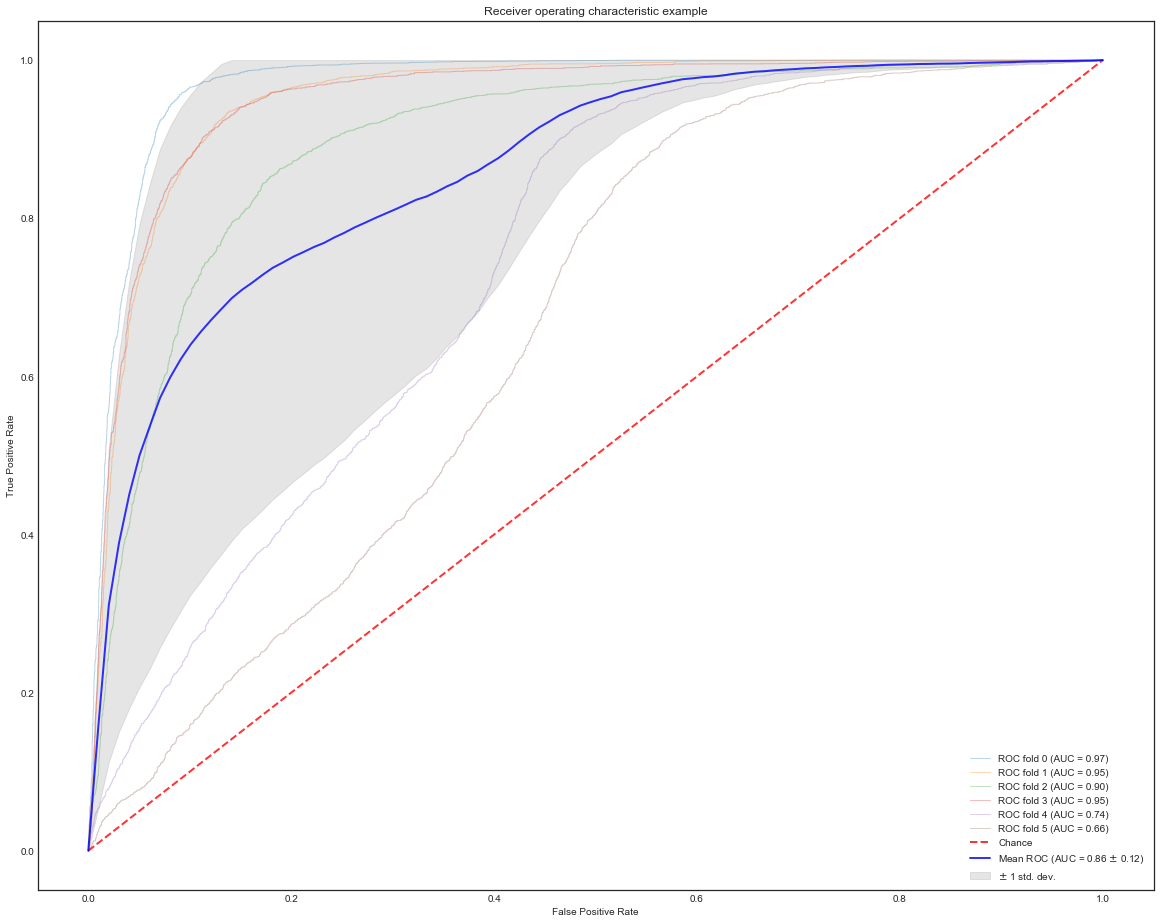

In [45]:
#Receiver Operating Characteristic (ROC) with cross validation
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
from scipy import interp
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=6)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(20,16))

i = 0
for train, test in cv.split(X_resampled, y_resampled):
    probas_ = log_model.fit(X_resampled[train], y_resampled[train]).predict_proba(X_resampled[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_resampled[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1


plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()